In [1]:
config_yaml = '''
# Data parameters
data_path: '/home/ruslan/data/datasets/t265_straight/'
train_sequences: ['yamskoe_train', 'gz_0_0_0', 'gz_0_0_90', 'gz_0_90_0', 'gz_90_0_0', 'gz_90_0_90']
dev_sequences: ['yamskoe_test', 'gz_0_0_0_test']
test_sequences: ['yamskoe_test', 'gz_0_0_0_test', 'gz_0_0_90_test', 'gz_0_90_0_test', 'gz_90_0_0_test', 'gz_90_0_90_test']
plot_views: ['xy', 'xz']

# Camera parameters
camera_matrix_l: [
    [285.66650390625, 0.0,               421.8902893066406],
    [0.0,             286.7117919921875, 409.32861328125],
    [0.0,             0.0,               1.0],
]
camera_matrix_r: [
    [285.41558837890625, 0.0,             428.9866943359375],
    [0.0,                286.59228515625, 410.2189025878906],
    [0.0,                0.0,             1.0],
]
original_image_h: 800
original_image_w: 848
distance_btw_cameras: 0.064

# Model parameters
backbone_flow: 'resnet50'
backbone_pose: 'mobilenetv2'
backbone_depth: 'resnet50'
image_h: 224
image_w: 224
posenet_activation: 'relu'
min_depth: 0.5
max_depth: 2
scale_rot: 0.01
scale_tr: 0.01
bino_depth: True
grayscale_load: False
init_binocular_noise: 1

# Training parameters
num_epochs: 6
batch_size: 14
learning_rate: 0.0001
lr_switch_after: 3
reverse_runs: True
max_frames_skip: 3
random_seed: 42
parallel_generation: False
mixed_precision: False
distributed_training: False

# Loss parameters
lambda_smoothness_flow: 0.01
lambda_smoothness_depth: 0.01
lambda_flow_consistency: 0.01
feature_loss_coef: 0
blur_before_loss: True
remove_blur_after: 1

# Predict parameters
skip_frames_predict: 2
min_depth_on_plot: 0.5

# Debug parameters
debug_mode: False
load_weights: False
#load_weights_from: 'wandb/run-20200821_184219-1yxun87j/' # KITTI
load_weights_from: 'wandb/run-20200822_150548-j82xq94p/' # KITTI
'''

In [2]:
import yaml
from argparse import Namespace

config_init = Namespace()
config_init.__dict__ = yaml.safe_load(config_yaml)

In [3]:
import load_config
load_config.initialize(config_init=config_init, use_wandb=False)

from load_config import *
from data_utils import *
from models import *
from train_eval_utils import *
from plot_utils import *

In [4]:
# Models
flow_net = FlowNet()
depth_net = DepthNet()
pose_net = PoseNet()

flow_net.compile()
depth_net.compile()
pose_net.compile()

kernel found: conv1_conv/kernel:0
kernel found: conv1_conv_2/kernel:0
kernel found: Conv1/kernel:0


In [5]:
# plot_depth_flow(depth_net, flow_net)

In [6]:
seq = OdoSequence(config.dev_sequences[0])
idx = len(seq) // 2
img_l = tf.constant(imread(seq.images_l[idx])[None], dtype=tf.float32)
img_r = tf.constant(imread(seq.images_r[idx])[None], dtype=tf.float32)
img_p = tf.constant(imread(seq.images_l[idx - 1])[None], dtype=tf.float32)

flows = flow_net(tf.concat([img_l, img_p], 3), training=False)
depths = depth_net(tf.concat([img_l, img_r], 3), training=False)
depths = [tf.cast(depth, tf.float64) for depth in depths]
depth = depths[0]
# depth = depth * 0 + 1

stereo_transform = tf.constant(config_runtime.right_left_transform, dtype=depth.dtype)
warp, _, border_mask_r = get_warp(
    depth,
    stereo_transform,
    config_runtime.camera_matrix_l,
    config_runtime.inv_camera_matrix_l,
)
restored_r = tfa.image.dense_image_warp(img_r, -warp)

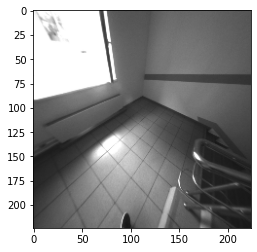

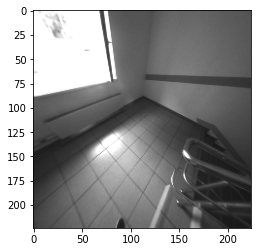

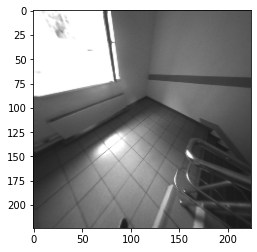

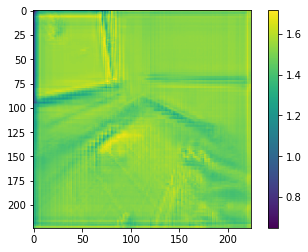

In [7]:
plt.imshow(img_l[0].numpy())
plt.show()
plt.imshow(img_r[0].numpy())
plt.show()
plt.imshow(restored_r[0].numpy())
plt.show()
plt.imshow(depth[0].numpy())
plt.colorbar()
plt.show()